In [2]:
from pathlib import Path
from typing import Optional

import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import cv2

from bezier import StrokeData

LINE_STROKES_DATA_DIR = Path("../datasets/IAM/lineStrokes")
LINE_LABELS_DATA_DIR = Path("../datasets/IAM/ascii")
LINE_IMAGES_DATA_DIR = Path("../datasets/IAM/lineImages")

In [3]:
def _get_line_from_labels_file(
    labels_file: Path, line_idx: int
) -> Optional[str]:
    """Gets the line label from the labels file.

    Args:
        labels_file (Path): The labels file path.
        line_idx (int): The line index.

    Returns:
        The line label. None if the line label is not found.

    Raises:
        ValueError: If the labels file is invalid.
        FileNotFoundError: If the labels file is not found.
        ValueError: If the labels file is not a file.
        ValueError: If the line label index is not a number.
    """
    # Check if the labels file is valid.
    if not isinstance(labels_file, Path):
        raise ValueError(
            f"Invalid labels file: {labels_file}. Must be an instance of {Path}."
        )

    # Check if the labels file exists.
    if not labels_file.exists():
        raise FileNotFoundError(f"Labels file not found: {labels_file}.")

    # Check if the labels file is a file.
    if not labels_file.is_file():
        raise ValueError(f"Labels file is not a file: {labels_file}.")

    # Check if the line label index is valid.
    if not isinstance(line_idx, int):
        raise ValueError(
            f"Invalid line label index: {line_idx}. Must be an integer."
        )

    # Get the line label from the labels file.
    with open(labels_file, "r", encoding="utf-8") as file:
        # The index of the line where the line labels start (CSR line).
        labels_start_idx = 0

        for i, line in enumerate(file):
            # Check if we have found CSR line and save the index.
            if line.startswith("CSR:"):
                labels_start_idx = i

            if (
                labels_start_idx > 0  # Ensure we have found the CSR line.
                and i
                == labels_start_idx
                + line_idx
                + 1  # Add 1 to skip the blank line after the CSR line.
            ):
                # Only keep the characters that are in the IAM dataset.
                return "".join(
                    [char for char in line if char.isalnum() or char == " "]
                )

    # If we have not found the line label, return None.
    return None


def _filter_and_get_stroke_file_paths(
    *, root: str, stroke_files: list[str]
) -> list[Path]:
    """Filter the stroke files and return a list of pathlib.Path objects representing the files.

    Args:
        root (str): The root directory of the stroke files.
        stroke_files (list[str]): A list of file names of the stroke files.

    Returns:
        list[Path]: A list of pathlib.Path objects representing the stroke files.
    """
    stroke_file_paths = [
        # Get the full path to the stroke file.
        Path(root) / Path(file)
        for file in stroke_files
        if file.endswith(".xml")
        # Don't include these files. They are invalid or missing data.
        and not file.startswith(
            "z01-000z"
        )  # Exclude files starting with "z01-000z".
        and not file.startswith(
            "a08-551z-08"
        )  # Exclude files starting with "a08-551z-08".
        and not file.startswith(
            "a08-551z-09"
        )  # Exclude files starting with "a08-551z-09".
    ]

    assert all(
        not (
            file.name.startswith("z01-000z")
            and file.name.startswith("a08-551z-08")
            and file.name.startswith("a08-551z-09")
        )
        for file in stroke_file_paths
    ), (
        "Invalid stroke files. "
        'The stroke files must not start with "z01-000z", "a08-551z-08", or "a08-551z-09".'
    )

    return stroke_file_paths


def _get_label_from_stroke_file(
    stroke_file: Path,
) -> tuple[Optional[str], str, Path]:
    """Gets the line label and the labels file name that the label belongs to.

    Args:
        stroke_file (Path): The stroke file path.

    Returns:
        The line label, the label file name, and the image file path.
        None if the line label is not found.

    Raises:
        ValueError: If the stroke file is invalid.
        FileNotFoundError: If the stroke file is not found.
        ValueError: If the stroke file is not an XML file.
        ValueError: If the line label index is not a number.
    """
    # Check if the stroke file is valid.
    if not isinstance(stroke_file, Path):
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an instance of {Path}."
        )

    if not stroke_file.is_file():
        raise FileNotFoundError(f"Stroke file not found: {stroke_file}.")

    if stroke_file.suffix != ".xml":
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an XML file."
        )

    # Get the stroke file name without the extension.
    stroke_file_name = stroke_file.stem  # e.g. a01-000u-01

    # Get the line label index.
    line_label_idx_chars = stroke_file_name[-2:]  # e.g. 01
    if not line_label_idx_chars.isdigit():
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. "
            f"Label line index must be a number."
        )
    line_label_idx = int(line_label_idx_chars)

    # Get the labels file directory and name.
    root_labels_dir = stroke_file_name[:3]  # e.g. a01
    sub_labels_dir = stroke_file_name[:7]  # e.g. a01-000
    labels_file_name = stroke_file_name[:-3]  # e.g. a01-000u

    # Get the labels file path. e.g. ../datasets/IAM/ascii/a01/a01-000/a01-000u.txt
    labels_file = (
        LINE_LABELS_DATA_DIR
        / root_labels_dir
        / sub_labels_dir
        / f"{labels_file_name}.txt"
    )

    image_file = (
        LINE_IMAGES_DATA_DIR
        / root_labels_dir
        / sub_labels_dir
        / f"{labels_file_name}-{line_label_idx_chars}.tif"
    )
    assert image_file.exists(), f"Image file not found: {image_file}."

    # Get the line label from the labels file.
    return (
        _get_line_from_labels_file(labels_file, line_label_idx),
        labels_file_name,
        image_file,
    )


def _parse_stroke_element(stroke_elem: ET.Element) -> StrokeData:
    """Parses the stroke element.

    Args:
        stroke (ET.Element): The stroke element.

    Returns:
        The stroke data, which contains the x points, y points, time stamps,
        and pen_ups information.

    Raises:
        ValueError: If the stroke element is invalid.
    """
    # Check if the stroke element is valid.
    if not isinstance(stroke_elem, ET.Element):
        raise ValueError(
            f"Invalid stroke ET element: {stroke_elem}. Must be an instance of {ET.Element}."
        )

    x_points = []
    y_points = []
    time_stamps = []
    pen_ups = []
    fst_timestamp = 0

    # Go through each point in the stroke.
    for i, point in enumerate(stroke_elem.findall("Point")):
        x_points.append(float(point.attrib["x"]))
        y_points.append(float(point.attrib["y"]))

        if not time_stamps:
            # Ensure first time stamp is 0, not the actual time stamp.
            fst_timestamp = float(point.attrib["time"])
            time_stamps.append(0)
        else:
            time_stamps.append(float(point.attrib["time"]) - fst_timestamp)

        if i == len(stroke_elem.findall("Point")) - 1:
            # If this is the last point in the stroke, the pen is up.
            pen_ups.append(1)
        else:
            # If this is not the last point in the stroke, the pen is down.
            pen_ups.append(0)

    assert (
        len(x_points) == len(y_points) == len(time_stamps) == len(pen_ups)
    ), (
        f"Invalid stroke element: {stroke_elem}. "
        "The number of x points, y points, time stamps, and pen ups must be equal."
    )

    return StrokeData(x_points, y_points, time_stamps, pen_ups)


def _get_strokes_from_stroke_file(stroke_file: Path) -> list[StrokeData]:
    """Gets the list of stroke data from the stroke file.

    Args:
        stroke_file (Path): The stroke file path.

    Returns:
        The list of stroke data.

    Raises:
        ValueError: If the stroke file is invalid.
        FileNotFoundError: If the stroke file is not found.
        ValueError: If the stroke file is not an XML file.
    """
    # Check if the stroke file is valid.
    if not isinstance(stroke_file, Path):
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an instance of {Path}."
        )

    if not stroke_file.is_file():
        raise FileNotFoundError(f"Stroke file not found: {stroke_file}.")

    if stroke_file.suffix != ".xml":
        raise ValueError(
            f"Invalid stroke file: {stroke_file}. Must be an XML file."
        )

    tree = ET.parse(stroke_file)
    root = tree.getroot()
    stroke_set = root.find("StrokeSet")

    strokes = [
        _parse_stroke_element(stroke)
        for stroke in stroke_set.findall("Stroke")
    ]

    # Normalize the strokes.
    max_y = float(
        root.find("WhiteboardDescription/DiagonallyOppositeCoords").attrib["y"]
    )

    for stroke in strokes:
        min_x = min(stroke.x_points)
        min_y = min(stroke.y_points)

        # Shift x and y points to start at 0.
        stroke.x_points = [x - min_x for x in stroke.x_points]
        stroke.y_points = [y - min_y for y in stroke.y_points]

        # Scale points so that the y_points are between 0 and 1. The x_points will be scaled
        # by the same amount, to preserve the aspect ratio.
        scale = (
            1 if max_y - min_y == 0 else 1 / (max_y - min_y)
        )  # Avoid division by 0.

        stroke.x_points = [x * scale for x in stroke.x_points]
        stroke.y_points = [y * scale for y in stroke.y_points]

        assert all(0 <= y <= 1 for y in stroke.y_points), (
            f"Invalid stroke file: {stroke_file}. "
            f"All y-points must be between 0 and 1."
        )

    assert all(
        len(stroke.x_points)
        == len(stroke.y_points)
        == len(stroke.time_stamps)
        == len(stroke.pen_ups)
        for stroke in strokes
    ), (
        f"Invalid stroke file: {stroke_file}. "
        "The number of x points, y points, time stamps, and pen ups must be equal."
    )

    return strokes

In [4]:
files = []

for root, _, stroke_files in os.walk(LINE_STROKES_DATA_DIR):
    # Get all stroke files in the directory.
    stroke_files = _filter_and_get_stroke_file_paths(
        root=root, stroke_files=stroke_files
    )

    # Go through each stroke file in the directory.
    for stroke_file in stroke_files:
        # Get the label for the stroke file.
        (
            line_label,
            labels_file_name,
            label_image_file,
        ) = _get_label_from_stroke_file(stroke_file)

        if line_label is None:
            break
        # Get the strokes from the stroke file.
        strokes = _get_strokes_from_stroke_file(stroke_file)
        files.append(
            (
                line_label,
                labels_file_name,
                label_image_file,
                stroke_file,
                len(strokes),
            )
        )

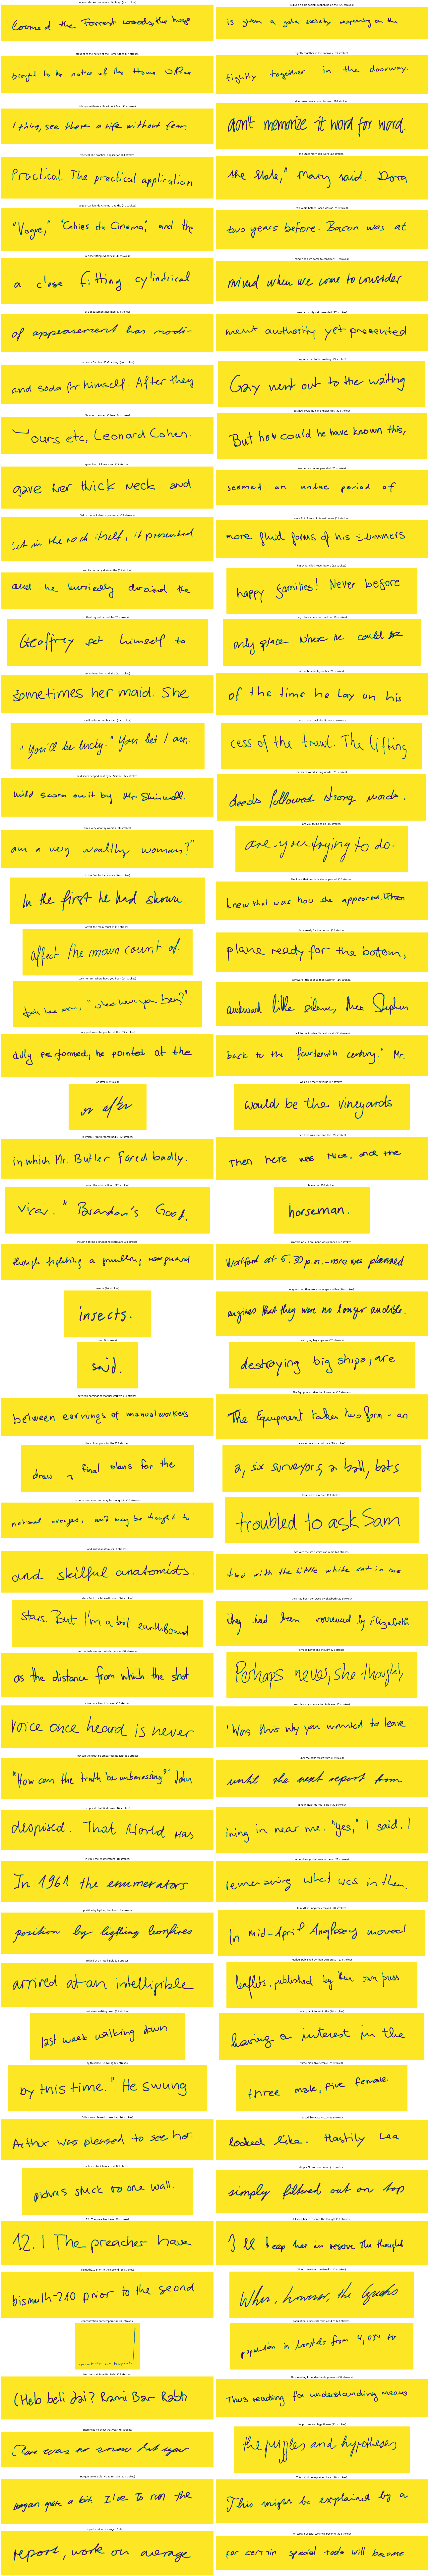

In [5]:
n_samples = 100
random_indices = np.random.choice(len(files), size=n_samples, replace=False)

fig, axs = plt.subplots(50, 2, figsize=(30, 180))
for i, idx in enumerate(random_indices):
    (
        line_label,
        labels_file_name,
        label_image_file,
        stroke_file,
        num_strokes,
    ) = files[idx]
    axs[i // 2, i % 2].imshow(plt.imread(label_image_file))
    axs[i // 2, i % 2].set_title(f"{line_label} ({num_strokes} strokes)")
    axs[i // 2, i % 2].axis("off")
plt.tight_layout()
plt.show()

Line label: loomed the Forrest woods the huge
Labels file name: l09-002z
Label image file: ../datasets/IAM/lineImages/l09/l09-002/l09-002z-05.tif
Number of strokes: 13
Line label: is given a gala society reopening on the 
Labels file name: c02-059z
Label image file: ../datasets/IAM/lineImages/c02/c02-059/c02-059z-04.tif
Number of strokes: 29
Line label: brought to the notice of the Home Office
Labels file name: h02-037
Label image file: ../datasets/IAM/lineImages/h02/h02-037/h02-037-03.tif
Number of strokes: 37
Line label: tightly together in the doorway
Labels file name: n08-066z
Label image file: ../datasets/IAM/lineImages/n08/n08-066/n08-066z-04.tif
Number of strokes: 33
Line label: I thing see there a life without fear
Labels file name: d06-404z
Label image file: ../datasets/IAM/lineImages/d06/d06-404/d06-404z-06.tif
Number of strokes: 45
Line label: dont memorize it word for word
Labels file name: f03-255z
Label image file: ../datasets/IAM/lineImages/f03/f03-255/f03-255z-04.tif
Nu

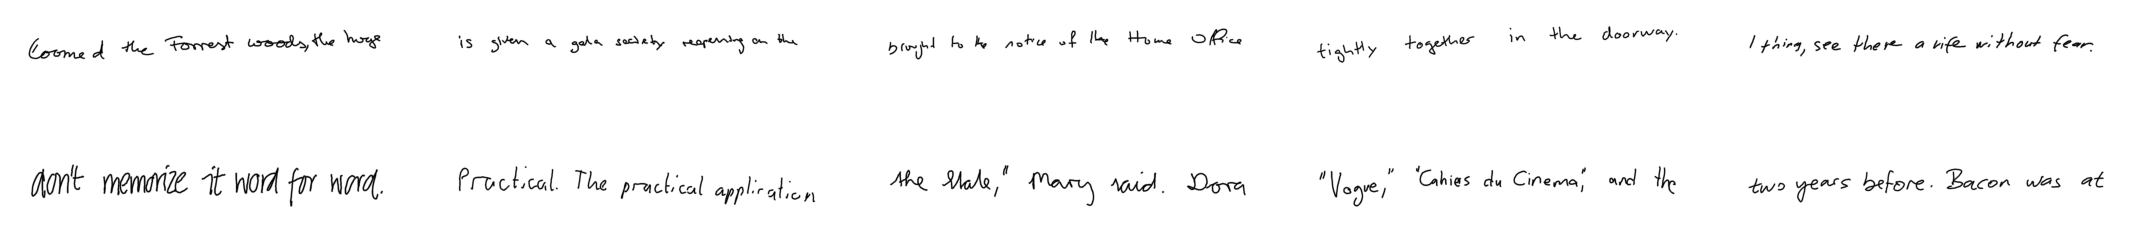

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 5))
for i, ax in enumerate(axes.flatten()):
    (
        line_label,
        labels_file_name,
        label_image_file,
        stroke_file,
        num_strokes,
    ) = files[random_indices[i]]
    print(f"Line label: {line_label}")
    print(f"Labels file name: {labels_file_name}")
    print(f"Label image file: {label_image_file}")
    print(f"Number of strokes: {num_strokes}")
    image = cv2.imread(str(label_image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis("off")
plt.tight_layout()
plt.show()